# Analyse Tortenguss

First you can find the imports and the picture paths. Currently absolute paths are used, so you **need to adjust this path** in order to get the code running. Furthermore picture specific properties such as the raw pattern are defined. They were read out manually. The showArray function can be used for debugging purposes.

In [3]:
import numpy as np
import rawpy
import matplotlib.pyplot as plt
import csv
import os
from matplotlib import pyplot as plt
from scipy.stats import linregress

cwd = os.getcwd()
images = os.path.dirname(cwd) + "/experiments/tortenguss-diffusion/pictures/"
areas = images + "areas.csv"
color_desc = {0: "R", 1: "G", 2: "B", 3: "G"}
raw_pattern = [[1,0], [2,3]]

def showArray(arr):
    plt.imshow(arr, interpolation='nearest')
    plt.show()

Now we define a function, that gives us the boundaries for a certain image, as defined in the areas.csv file.

In [104]:
def boundaries(key):
    csv_path = images + "areas.csv"
    with open(csv_path) as csvfile:
        csvreader = csv.reader(csvfile, delimiter = ";")
        for row in csvreader:
            if row[1] == "NA":
                raise RuntimeError("Areas not defined.")
            if row[0] == key:
                return (int(row[1]), int(row[2]), int(row[3]), int(row[4]))


The read function reads in an image and returns the black value and an array containing the pixel values of the image.

In [105]:
def read(key):
    x, y, xlen, ylen = boundaries(key)
    y = y + y%2
    x = x + x%2
    xlen = xlen + xlen%2
    ylen = ylen + ylen%2
    img_data = None
    with rawpy.imread(images+"1.dng") as raw:
        img_data = raw.raw_image.copy()
        black = np.array(raw.black_level_per_channel).mean()
    ret = img_data[y:y+ylen,x:x+xlen]
    return (ret, black)

The intensity function gives us the intensity depending on two arrays and their black values, as well as a colour value. The intensities function, does this but accepts instead of arrays and black values, keys, as found in areas.csv and a reader function. This argument can be used for rasterization, as explained below.

In [106]:
def intensities(key, ctrl_key, col=None, reader_func=read):
    ret, black = reader_func(key)
    retctrl, blackctrl = read(ctrl_key)
    x, y, xlen, ylen = boundaries(key)
    if ret.shape  == (ylen, xlen):
        return intensity(ret, retctrl, black, blackctrl, col)
    else:
        return [intensity(arr, retctrl, black, blackctrl, col) for arr in ret]

def intensity(arr, arr_ctrl, black, black_ctrl, col):
    val = (singleColorArray(col, arr).mean()-black)
    c_val = (singleColorArray(col, arr_ctrl).mean()-black_ctrl)
    return np.log10(c_val/val)

The single color array function, returns from a given array only those pixels, that are of the provided color. They are put into a single list.

In [107]:
def singleColorArray(target_color, arr):
    if target_color == None:
        return arr
    new_arr = []
    for index_r, row in enumerate(arr):
        for index_c, col in enumerate(row):
            r_ind = index_r
            c_ind = index_c
            color = None 
            if r_ind % 2 == 0:
                if c_ind % 2 == 0:
                    color = 1
                else:
                    color = 0
            else:
                if c_ind % 2 == 0:
                    color = 2
                else:
                    color = 3
            if color_desc[color] == target_color:
                new_arr.append(col)
            else:
                pass
    return np.array(new_arr)

The rasterization functions raster an image into rows of a certain height, they then return an array containing subarrays of the original array, but with the provided height. The defined convenience function make the usage with the intensities function easier and allow for easy plotting.

In [ ]:
def rasterizeImage(key, row_height=None, x_coords=False):
    rows = []
    arr, black = read(key)
    x, y, xlen, ylen = boundaries(key)
    if row_height == None:
        row_height = ylen
    ylen = ylen - ylen%row_height #this guarantees, that also the last row has row_height
    row_no = int(ylen/row_height)
    if x_coords:
        return [n for n in range(row_no)][:]
    rows = [arr[n*row_height:(n+1)*row_height] for n in range(row_no)]
    return (np.array(rows), black)

def rasterizeImageWrapperGenerator(row_height=None):
    def _rasterize(_key):
        return rasterizeImage(_key, row_height=row_height)
    return _rasterize

def rasterXCoords(key, row_height=None):
    return rasterizeImage(key, row_height=row_height, x_coords=True)

raster = rasterizeImageWrapperGenerator #definition for ease of use

And now we analyze the data.

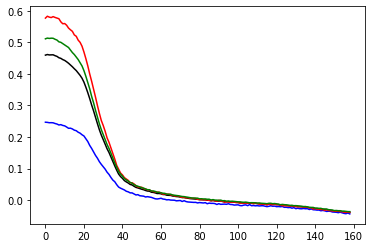

In [108]:
plt.plot(rasterXCoords("1-tint", 2),intensities("1-tint", "1-ctrl", reader_func=raster(2)), color="k")
plt.plot(rasterXCoords("1-tint", 2),intensities("1-tint", "1-ctrl", col="B", reader_func=raster(2)), color="b")
plt.plot(rasterXCoords("1-tint", 2),intensities("1-tint", "1-ctrl", col="R", reader_func=raster(2)), color="r")
plt.plot(rasterXCoords("1-tint", 2),intensities("1-tint", "1-ctrl", col="G", reader_func=raster(2)), color="g")

Nun die objektorientierte Version.

In [ ]:
class DiffusionTimeSeries:
    pass

class DiffusionMeasurement:
    
    @staticmethod
    def intensity(pixels, constant_offset):
        return pixels.mean() - constant_offset
    
    @staticmethod
    def absorbance(val, ctrl):
        np.log10(ctrl/val)
    
    @staticmethod
    def single_color_intensity(pixels, constant_offset, colour_key, camera):
        single_colour_array = DiffusionMeasurement.colour_filtered_array(pixels, colour_key, camera)
        return DiffusionMeasurement.intensity(single_colour_array, constant_offset)
    
    @staticmethod
    def colour_filtered_array(array, colour, camera):
        new_list = []    
        for r_ind, row in enumerate(array):
            for c_ind, col in enumerate(row):
                if r_ind % 2 == 0:
                    if c_ind % 2 == camera.pattern[0][0]:
                        local_colour = camera.pattern[0][0]
                    else:
                        local_colour = camera.pattern[0][1]
                else:
                    if c_ind % 2 == camera.pattern[1][0]:
                        local_colour = camera.pattern[1][0]
                    else:
                        local_colour = camera.pattern[1][1]
                if camera.colors[local_colour] == colour:
                    new_list.append(col)
        return np.array(new_list)
    
    def __init__(self, path, control_key, boundaries_file, camera, main_key, complete_main_boundaries_used = False):
        self.camera = camera
        
        with rawpy.imread(path) as raw_file:
            self.pixels = raw_file.raw_image.copy()
            self.black = np.array(raw_file.black_level_per_channel.mean).mean()
            
        with open(boundaries_file) as csv_file:
            csv_reader = csv.reader(csv_file, delimiter = ";")
            for row in csv_reader:
                if row[0] == control_key:
                    self.control_boundaries = Boundary(int(row[1]), int(row[2]), int(row[3]), int(row[4]))
                if row[0] == main_key:
                    if main_boundaries_used:
                        self.main_boundaries = Boundary(int(row[1]), int(row[2]), int(row[3]), int(row[4]))
                    else:
                        self.main_boundaries = XBoundary(int(row[1]))
        
        if !main_boundaries_used:
            # initialize boundaries without main
            
        #cut out main pixels
        #calculate intensity of control
        #add rasterization support
        

        
            
            
            

class Camera:
    ios = Camera([[0,1], [3,2]], {0: "R", 1: "G", 2: "B", 3: "G"})
    android = Camera([[1,0], [2,3]] ,{0: "R", 1: "G", 2: "B", 3: "G"})
    
    def __init__(self, raw_pattern, color_desc):
        self.pattern = raw_pattern
        self.colors = color_desc
        
class Boundary:
    
    def __init__(x, y, xlen, ylen):
        self.x = x - x%2
        self.y = y - y%2
        self.xlen = xlen - xlen%2
        self.ylen = ylen - ylen%2
        
class XBoundary(Boundary):
    
    def __init__(x):
        self.x = x